In [1]:
# Cell 1 — Setup & Config
import os, json, math, random, time, pathlib, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

# ------------------------------
# Paths (EDIT THIS FIRST)
# ------------------------------
# Put the path of Duplication_Dataset/train (folders per person)
CANDIDATES = [
    "/kaggle/input/identification-dataset/Sentinel_FaceV1/Duplication_Dataset/train",
    "/kaggle/input/kyc_dataset/pytorch/default/1/Sentinel_FaceV1/Duplication_Dataset/train",
    "/kaggle/input/Sentinel_FaceV1/Duplication_Dataset/train",
]
DATA_ROOT = None
for p in CANDIDATES:
    if os.path.isdir(p):
        DATA_ROOT = p
        break
# fallback: set manually if None
# DATA_ROOT = "/kaggle/input/.../Sentinel_FaceV1/Duplication_Dataset/train"

assert DATA_ROOT and os.path.isdir(DATA_ROOT), f"Dataset path not found. Set DATA_ROOT manually. Tried: {CANDIDATES}"
print("Using dataset:", DATA_ROOT)

WORK = Path("/kaggle/working")
ART = WORK / "artifacts"; ART.mkdir(exist_ok=True, parents=True)

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ------------------------------
# Hyperparameters (tweakable)
# ------------------------------
IMG_SIZE = 160
EMB_DIM = 512
BATCH_SIZE = 128 if DEVICE == "cuda" else 64
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 1e-4
MARGIN_M = 0.5
SCALE_S = 30.0
VAL_IDENTITIES_FRACTION = 0.20   # hold-out identities entirely
NUM_WORKERS = 2

# Normalization (ImageNet, works well for MobileNetV3)
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

CONFIG = {
    "img_size": IMG_SIZE,
    "emb_dim": EMB_DIM,
    "mean": MEAN,
    "std": STD,
    "backbone": "mobilenet_v3_small",
}
with open(ART/"config.json","w") as f: json.dump(CONFIG, f, indent=2)
print("Saved config:", ART/"config.json")


Using dataset: /kaggle/input/identification-dataset/Sentinel_FaceV1/Duplication_Dataset/train
Device: cuda
Saved config: /kaggle/working/artifacts/config.json


In [2]:
# Cell 2 — Dataset & Split (identity-level)

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

full_ds = ImageFolder(DATA_ROOT)  # assumes directory-per-identity
classes = full_ds.classes
n_id = len(classes)
print(f"Identities found: {n_id}")

# Map: class -> indices
indices_by_class = {}
for idx, (_, y) in enumerate(full_ds.samples):
    indices_by_class.setdefault(y, []).append(idx)

# Identity-level split (unseen IDs for val)
all_ids = list(indices_by_class.keys())
random.shuffle(all_ids)
val_ids = set(all_ids[: max(1, int(len(all_ids)*VAL_IDENTITIES_FRACTION))])
train_ids = set(all_ids) - val_ids

train_indices = [i for cid in train_ids for i in indices_by_class[cid]]
val_indices   = [i for cid in val_ids   for i in indices_by_class[cid]]

# Wrap with different transforms
class WrappedDataset(torch.utils.data.Dataset):
    def __init__(self, base: ImageFolder, indices, tfm):
        self.base = base
        self.indices = indices
        self.tfm = tfm
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        path, y = self.base.samples[self.indices[i]]
        try:
            img = Image.open(path).convert("RGB")
        except Exception:
            # recoverable: return a black image to avoid crashing the epoch
            img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
        img = self.tfm(img)
        return img, y

train_ds = WrappedDataset(full_ds, train_indices, train_tfms)
val_ds_raw = WrappedDataset(full_ds, val_indices, val_tfms)

# For ArcFace classification, we need labels only for train identities.
# Remap labels so train IDs go from 0..(train_classes-1). Val isn't used for CE.
train_id_map = {cid:i for i, cid in enumerate(sorted(train_ids))}
inv_class_to_name = {i:name for i,name in enumerate(classes)}

def relabel_train(y):
    return train_id_map[y]

class RelabeledDataset(torch.utils.data.Dataset):
    def __init__(self, base_ds, relabel_fn):
        self.base_ds = base_ds
        self.relabel_fn = relabel_fn
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, i):
        x, y = self.base_ds[i]
        return x, self.relabel_fn(y)

train_ds_rel = RelabeledDataset(train_ds, relabel_train)

train_loader = DataLoader(train_ds_rel, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

val_loader = DataLoader(val_ds_raw, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train images: {len(train_ds_rel)} across {len(train_ids)} IDs")
print(f"Val (unseen IDs) images: {len(val_ds_raw)} across {len(val_ids)} IDs")


Identities found: 100
Train images: 4000 across 80 IDs
Val (unseen IDs) images: 1000 across 20 IDs


In [6]:
# Cell 3 — Model (MobileNetV3-Small + ArcFace Head)
# FIX: use the classifier **first** Linear in_features (=576) for MobileNetV3-Small.
# Previously we read classifier[-1].in_features (=1024) which mismatched the 576-d
# pooled features returned when classifier is replaced by Identity → shape error.

class L2Norm(nn.Module):
    def forward(self, x, eps=1e-6):
        return F.normalize(x, p=2, dim=1, eps=eps)

class ArcMarginProduct(nn.Module):
    """ArcFace head: cos(theta + m) * s"""
    def __init__(self, emb_dim, num_classes, s=30.0, m=0.5, easy_margin=False):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, emb_dim))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embeddings, labels):
        W = F.normalize(self.weight, dim=1)
        x = F.normalize(embeddings, dim=1)
        cosine = torch.matmul(x, W.t()).clamp(-1, 1)
        sine = torch.sqrt((1.0 - cosine**2).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s
        return logits

class Embedder(nn.Module):
    def __init__(self, emb_dim=512):
        super().__init__()
        backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # ✅ Correct input feature size for head (576 on v3-small)
        try:
            in_feats = backbone.classifier[0].in_features  # first Linear: 576 -> 1024
        except Exception:
            # Fallback: infer by running features + GAP once
            backbone.eval()
            with torch.no_grad():
                dummy = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
                feats = backbone.features(dummy)
                feats = F.adaptive_avg_pool2d(feats, 1).reshape(1, -1)
                in_feats = feats.shape[1]

        # Replace classifier; keep backbone up to GAP+flatten (returns 576-d)
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # Small head to emb_dim then L2-normalize
        self.head = nn.Sequential(
            nn.Linear(in_feats, emb_dim, bias=False),
            nn.BatchNorm1d(emb_dim),
        )
        self.l2 = L2Norm()

    def forward(self, x):
        feats = self.backbone(x)       # [B, 576]
        emb = self.head(feats)         # [B, emb_dim]
        emb = self.l2(emb)             # L2-normalized
        return emb

num_train_classes = len(train_ids)
model = Embedder(EMB_DIM).to(DEVICE)
arcface = ArcMarginProduct(EMB_DIM, num_train_classes, s=SCALE_S, m=MARGIN_M).to(DEVICE)

# Optimizer / Scheduler
optim = torch.optim.AdamW(
    list(model.parameters()) + list(arcface.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {total_params/1e6:.2f}M (lightweight)")


Trainable params: 1.22M (lightweight)


/tmp/ipykernel_37/2570141313.py:89: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


In [7]:
# Cell 4 — Training & Validation (AUC/EER/F1)
# NOTE: Labels coming from train_loader are ALREADY re-labeled (0..num_train_classes-1)
# via `train_ds_rel`. Do NOT remap again (this caused the KeyError).

CE = nn.CrossEntropyLoss()

@torch.no_grad()
def compute_val_metrics(embedder: nn.Module):
    embedder.eval()
    all_emb, all_lbl = [], []
    for xb, yb in val_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            embs = embedder(xb)
        all_emb.append(embs.cpu())
        all_lbl.append(yb)
    all_emb = torch.cat(all_emb, 0).numpy()
    all_lbl = torch.cat(all_lbl, 0).numpy()

    # Build balanced pairs (same/diff)
    rng = np.random.default_rng(123)
    by_id = {}
    for e, y in zip(all_emb, all_lbl):
        by_id.setdefault(int(y), []).append(e)
    ids = list(by_id.keys())

    pos_scores, neg_scores = [], []
    for y in ids:
        vecs = by_id[y]
        if len(vecs) >= 2:
            for _ in range(min(20, len(vecs)//2)):
                a, b = rng.choice(len(vecs), size=2, replace=False)
                s = float(np.dot(vecs[a], vecs[b]))
                pos_scores.append(s)

    # negative pairs across different IDs
    id_pairs = []
    for _ in range(len(pos_scores)):
        a, b = rng.choice(ids, size=2, replace=False)
        va = rng.choice(by_id[a])
        vb = rng.choice(by_id[b])
        id_pairs.append((va, vb))
    for va, vb in id_pairs:
        neg_scores.append(float(np.dot(va, vb)))

    y_true = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)

    # AUC
    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = float("nan")

    # find best threshold for F1
    thresholds = np.linspace(-1, 1, 400)
    best_f1, best_t = 0.0, 0.0
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    # EER (where FPR≈FNR)
    def eer(scores, labels):
        fprs, fnrs = [], []
        for t in thresholds:
            yp = (scores >= t).astype(int)
            tn = np.sum((yp==0) & (labels==0))
            fp = np.sum((yp==1) & (labels==0))
            fn = np.sum((yp==0) & (labels==1))
            tp = np.sum((yp==1) & (labels==1))
            fpr = fp / max(fp+tn, 1)
            fnr = fn / max(fn+tp, 1)
            fprs.append(fpr); fnrs.append(fnr)
        fprs, fnrs = np.array(fprs), np.array(fnrs)
        i = np.argmin(np.abs(fprs - fnrs))
        return float((fprs[i]+fnrs[i])/2.0)
    eer_v = eer(y_score, y_true)

    return {
        "auc": float(auc),
        "eer": float(eer_v),
        "f1_best": float(best_f1),
        "tau_best": float(best_t),
        "n_pos": int(len(pos_scores)),
        "n_neg": int(len(neg_scores)),
    }

BEST = {"auc": -1.0}
CKPT_EMB = ART/"mobilenetv3_arcface_embedder.pth"
CKPT_ARC = ART/"mobilenetv3_arcface_head.pth"

for epoch in range(1, EPOCHS+1):
    model.train(); arcface.train()
    running_loss = 0.0
    t0 = time.time()

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).long()  # already re-labeled; just move to device

        optim.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            emb = model(xb)
            logits = arcface(emb, yb)
            loss = CE(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        running_loss += float(loss.item())

    sched.step()
    train_loss = running_loss / max(1, len(train_loader))

    # Evaluate on unseen identities
    metrics = compute_val_metrics(model)
    auc, eer, f1b, tau = metrics["auc"], metrics["eer"], metrics["f1_best"], metrics["tau_best"]

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss={train_loss:.4f} | Val AUC={auc:.4f}  EER={eer:.4f}  F1@best={f1b:.4f}  τ={tau:.3f}")

    if auc > BEST["auc"]:
        BEST = {"epoch": epoch, **metrics}
        torch.save(model.state_dict(), CKPT_EMB)
        torch.save(arcface.state_dict(), CKPT_ARC)
        with open(ART/"best_metrics.json","w") as f: json.dump(BEST, f, indent=2)
        print("✅ Saved best:", CKPT_EMB.name, "and", CKPT_ARC.name)

print("Best metrics:", BEST)


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 01/20 | loss=18.4812 | Val AUC=0.7261  EER=0.3237  F1@best=0.6990  τ=0.489
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 02/20 | loss=16.3912 | Val AUC=0.7860  EER=0.3025  F1@best=0.7366  τ=0.338
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 03/20 | loss=14.8685 | Val AUC=0.8322  EER=0.2450  F1@best=0.7760  τ=0.273
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 04/20 | loss=13.4624 | Val AUC=0.8578  EER=0.2200  F1@best=0.7939  τ=0.228
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 05/20 | loss=12.0968 | Val AUC=0.8693  EER=0.2062  F1@best=0.7945  τ=0.233
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 06/20 | loss=10.8771 | Val AUC=0.8762  EER=0.2000  F1@best=0.8076  τ=0.163
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 07/20 | loss=9.7080 | Val AUC=0.8766  EER=0.1913  F1@best=0.8099  τ=0.178
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 08/20 | loss=8.7548 | Val AUC=0.8796  EER=0.1900  F1@best=0.8130  τ=0.178
✅ Saved best: mobilenetv3_arcface_embedder.pth and mobilenetv3_arcface_head.pth


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 09/20 | loss=7.9012 | Val AUC=0.8745  EER=0.1825  F1@best=0.8182  τ=0.153


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 10/20 | loss=7.1480 | Val AUC=0.8762  EER=0.1862  F1@best=0.8152  τ=0.153


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 11/20 | loss=6.4841 | Val AUC=0.8728  EER=0.1975  F1@best=0.8015  τ=0.138


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 12/20 | loss=5.9874 | Val AUC=0.8707  EER=0.2062  F1@best=0.8043  τ=0.108


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 13/20 | loss=5.6361 | Val AUC=0.8689  EER=0.2087  F1@best=0.8029  τ=0.098


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 14/20 | loss=5.2656 | Val AUC=0.8716  EER=0.2050  F1@best=0.8034  τ=0.098


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 15/20 | loss=5.0530 | Val AUC=0.8679  EER=0.2062  F1@best=0.8010  τ=0.093


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 16/20 | loss=4.8285 | Val AUC=0.8649  EER=0.2075  F1@best=0.7972  τ=0.078


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 17/20 | loss=4.6767 | Val AUC=0.8642  EER=0.2037  F1@best=0.7972  τ=0.068


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 18/20 | loss=4.6383 | Val AUC=0.8633  EER=0.2075  F1@best=0.7967  τ=0.083


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 19/20 | loss=4.5360 | Val AUC=0.8627  EER=0.2050  F1@best=0.7981  τ=0.083


/tmp/ipykernel_37/3866716900.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipykernel_37/3866716900.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 20/20 | loss=4.6147 | Val AUC=0.8623  EER=0.2037  F1@best=0.7985  τ=0.093
Best metrics: {'epoch': 8, 'auc': 0.87955, 'eer': 0.19, 'f1_best': 0.8130489335006275, 'tau_best': 0.17794486215538852, 'n_pos': 400, 'n_neg': 400}


{
  "auc": 0.8794375000000001,
  "eer": 0.18875,
  "f1_best": 0.8115577889447236,
  "tau_best": 0.17794486215538852,
  "n_pos": 400,
  "n_neg": 400
}


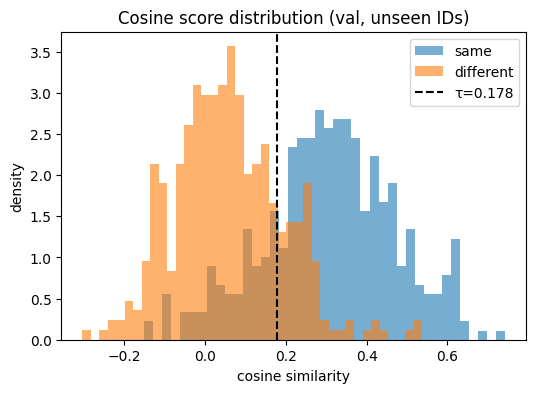

In [8]:
# Cell 5 — Visual Check (score hist & quick metrics)

# Reload best embedder (if saved)
if (ART/"mobilenetv3_arcface_embedder.pth").exists():
    model.load_state_dict(torch.load(ART/"mobilenetv3_arcface_embedder.pth", map_location=DEVICE))

def _compute_val_metrics_local(embedder: nn.Module):
    """Re-use the same metric logic to print a clean JSON block here."""
    embedder.eval()
    all_emb, all_lbl = [], []
    for xb, yb in val_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        with torch.no_grad():
            embs = embedder(xb)
        all_emb.append(embs.cpu())
        all_lbl.append(yb)
    all_emb = torch.cat(all_emb, 0).numpy()
    all_lbl = torch.cat(all_lbl, 0).numpy()

    rng = np.random.default_rng(123)
    by_id = {}
    for e, y in zip(all_emb, all_lbl):
        by_id.setdefault(int(y), []).append(e)
    ids = list(by_id.keys())

    pos_scores, neg_scores = [], []
    for y in ids:
        vecs = by_id[y]
        if len(vecs) >= 2:
            for _ in range(min(20, len(vecs)//2)):
                a, b = rng.choice(len(vecs), size=2, replace=False)
                pos_scores.append(float(np.dot(vecs[a], vecs[b])))

    for _ in range(len(pos_scores)):
        a, b = rng.choice(ids, size=2, replace=False)
        va = rng.choice(by_id[a]); vb = rng.choice(by_id[b])
        neg_scores.append(float(np.dot(va, vb)))

    y_true = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)

    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = float("nan")

    thresholds = np.linspace(-1, 1, 400)
    best_f1, best_t = 0.0, 0.0
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    def eer(scores, labels):
        fprs, fnrs = [], []
        for t in thresholds:
            yp = (scores >= t).astype(int)
            tn = np.sum((yp==0) & (labels==0))
            fp = np.sum((yp==1) & (labels==0))
            fn = np.sum((yp==0) & (labels==1))
            tp = np.sum((yp==1) & (labels==1))
            fpr = fp / max(fp+tn, 1)
            fnr = fn / max(fn+tp, 1)
            fprs.append(fpr); fnrs.append(fnr)
        fprs, fnrs = np.array(fprs), np.array(fnrs)
        i = np.argmin(np.abs(fprs - fnrs))
        return float((fprs[i]+fnrs[i])/2.0)

    return {
        "auc": float(auc),
        "eer": float(eer(y_score, y_true)),
        "f1_best": float(best_f1),
        "tau_best": float(best_t),
        "n_pos": int(len(pos_scores)),
        "n_neg": int(len(neg_scores)),
    }

m = _compute_val_metrics_local(model)
print(json.dumps(m, indent=2))

# Score distribution plot
@torch.no_grad()
def collect_scores(embedder):
    embedder.eval()
    all_emb, all_lbl = [], []
    for xb, yb in val_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        embs = embedder(xb)
        all_emb.append(embs.cpu()); all_lbl.append(yb)
    all_emb = torch.cat(all_emb,0).numpy()
    all_lbl = torch.cat(all_lbl,0).numpy()

    rng = np.random.default_rng(123)
    by_id = {}
    for e,y in zip(all_emb, all_lbl): by_id.setdefault(int(y), []).append(e)
    ids = list(by_id.keys())

    pos, neg = [], []
    for y in ids:
        v = by_id[y]
        if len(v) >= 2:
            for _ in range(min(20, len(v)//2)):
                a,b = rng.choice(len(v), 2, replace=False)
                pos.append(float(np.dot(v[a], v[b])))
    for _ in range(len(pos)):
        a,b = rng.choice(ids, 2, replace=False)
        va = rng.choice(by_id[a]); vb = rng.choice(by_id[b])
        neg.append(float(np.dot(va, vb)))
    return np.array(pos), np.array(neg)

pos, neg = collect_scores(model)

plt.figure(figsize=(6,4))
plt.hist(pos, bins=40, alpha=0.6, label="same", density=True)
plt.hist(neg, bins=40, alpha=0.6, label="different", density=True)
plt.axvline(m["tau_best"], color="k", linestyle="--", label=f"τ={m['tau_best']:.3f}")
plt.title("Cosine score distribution (val, unseen IDs)")
plt.xlabel("cosine similarity"); plt.ylabel("density"); plt.legend(); plt.show()


In [9]:
# Cell 6 — Save .pth and export ONNX

# 1) Embedding model only (for inference service)
EMBED_PTH = ART/"id_embedder_mobilenetv3_512.pth"
torch.save({"state_dict": model.state_dict(), "config": CONFIG}, EMBED_PTH)

# 2) Optional: classification head (for potential future fine-tuning)
HEAD_PTH = ART/"arcface_head.pth"
torch.save({
    "state_dict": arcface.state_dict(),
    "num_classes": len(train_ids),
    "m": MARGIN_M, "s": SCALE_S
}, HEAD_PTH)

# 3) ONNX export for portable inference
model.eval()
DUMMY = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
ONNX_PATH = ART/"id_embedder_mobilenetv3_512.onnx"
torch.onnx.export(
    model, DUMMY, ONNX_PATH,
    input_names=["images"], output_names=["embeddings"],
    dynamic_axes={"images": {0: "batch"}, "embeddings": {0: "batch"}},
    opset_version=17
)

def size_mb(p): 
    try:
        return os.path.getsize(p)/1024/1024
    except:
        return -1

print(f"Saved: {EMBED_PTH} ({size_mb(EMBED_PTH):.2f} MB)")
print(f"Saved: {ONNX_PATH} ({size_mb(ONNX_PATH):.2f} MB)")
print(f"Saved: {HEAD_PTH} ({size_mb(HEAD_PTH):.2f} MB)")


Saved: /kaggle/working/artifacts/id_embedder_mobilenetv3_512.pth (4.81 MB)
Saved: /kaggle/working/artifacts/id_embedder_mobilenetv3_512.onnx (4.68 MB)
Saved: /kaggle/working/artifacts/arcface_head.pth (0.16 MB)
